In [3]:
import librosa, librosa.display
import noisereduce as nr
import numpy as np
from glob import glob
import pandas as pd

# custom scripts
from util import data_address
from preprocessing_pipeline import *

In [4]:
PATH_DATA = data_address + 'VOiCES_devkit/'
PATH_TRAIN_INDEX = PATH_DATA + 'references/train_index.csv'
PATH_TEST_INDEX = PATH_DATA + 'references/test_index.csv'

In [5]:
df_train = pd.read_csv(PATH_TRAIN_INDEX)
df_test = pd.read_csv(PATH_TEST_INDEX)

In [6]:
df_train["category"] = "train"
df_test["category"] = "test"
df_merged = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
df_merged["full_path"] = PATH_DATA + df_merged["filename"]
df_merged["full_path_source"] = PATH_DATA + df_merged["source"]

In [8]:
# sort by speaker, segment, room, distractor, degrees, mic
df_merged = df_merged.sort_values(by=["speaker", "segment", "room", "distractor", "degrees", "mic"]).reset_index(drop=True)

In [9]:
df_merged

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,transcript,noisy_length,noisy_sr,noisy_time,source_length,source_sr,source_time,category,full_path,full_path_source
0,893,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
1,895,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
2,280,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
3,282,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
4,2969,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,780,283228,130,musi,distant-16k/speech/test/rm4/musi/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-musi-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19196,1471,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19197,1470,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19198,975,283228,130,tele,distant-16k/speech/test/rm4/tele/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-tele-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...


In [10]:
df = df_merged.copy() # working df
df["full_path"][64] ## same 32 speaker-segment observations
## if no difference after the pre-processing pipeline?

'./data/VOiCES_devkit/distant-16k/speech/train/rm1/babb/sp0083/Lab41-SRI-VOiCES-rm1-babb-sp0083-ch009960-sg0031-mc01-stu-clo-dg110.wav'

# Explore Signal Pre vs Post Noise Reduction

In [11]:
import librosa
import matplotlib.pyplot as plt

def display_waveplot(signal, sr):
    """
    Display waveplot of audio signal
    """
    librosa.display.waveshow(signal, sr=sr)

def plot_decorate(row, source=False, xlabel="Time (s)", ylabel="Amplitude", subtitle=""):
    """
    Decorate plot with metadata
    """
    plt.figure(figsize=(15, 5))
    if source:
        plt.title(f"Speaker: {row['speaker']}, Segment: {row['segment']}", fontsize=20)
    else:
        plt.title(f"Speaker: {row['speaker']}, Segment: {row['segment']}, Room: {row['room']}, Distractor: "
              f"{row['distractor']}, Degrees: {row['degrees']}, Mic: {row['mic']}", fontsize=20)
    if subtitle:
        plt.suptitle(subtitle, fontsize=20, y=1.05)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

def display_spectrogram(spectrogram, title=""):
    """
    Display spectrogram
    """
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(spectrogram)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

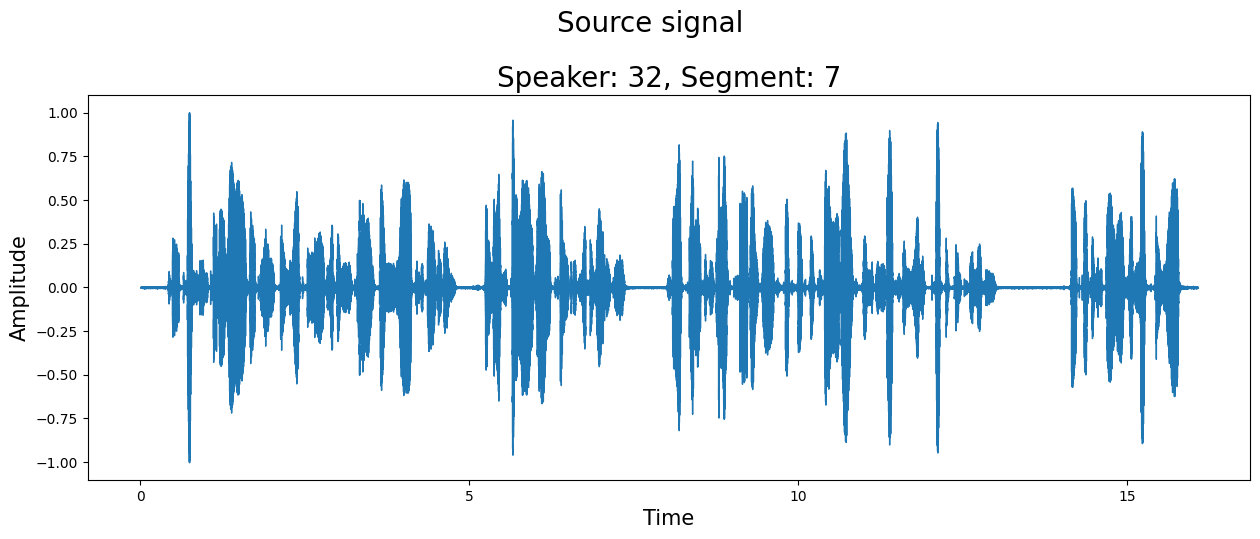

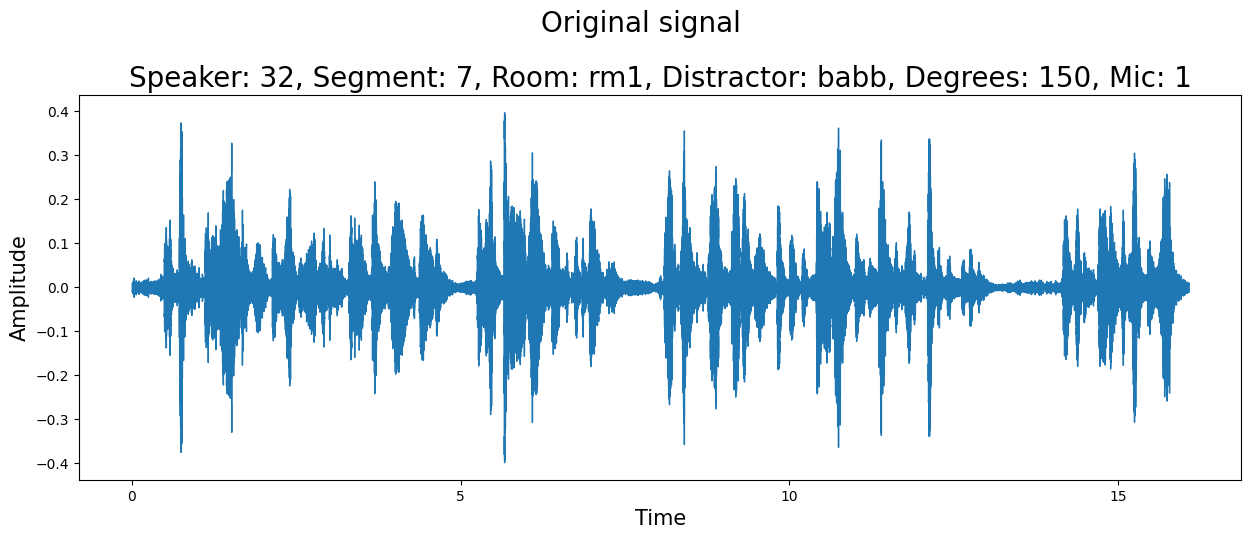

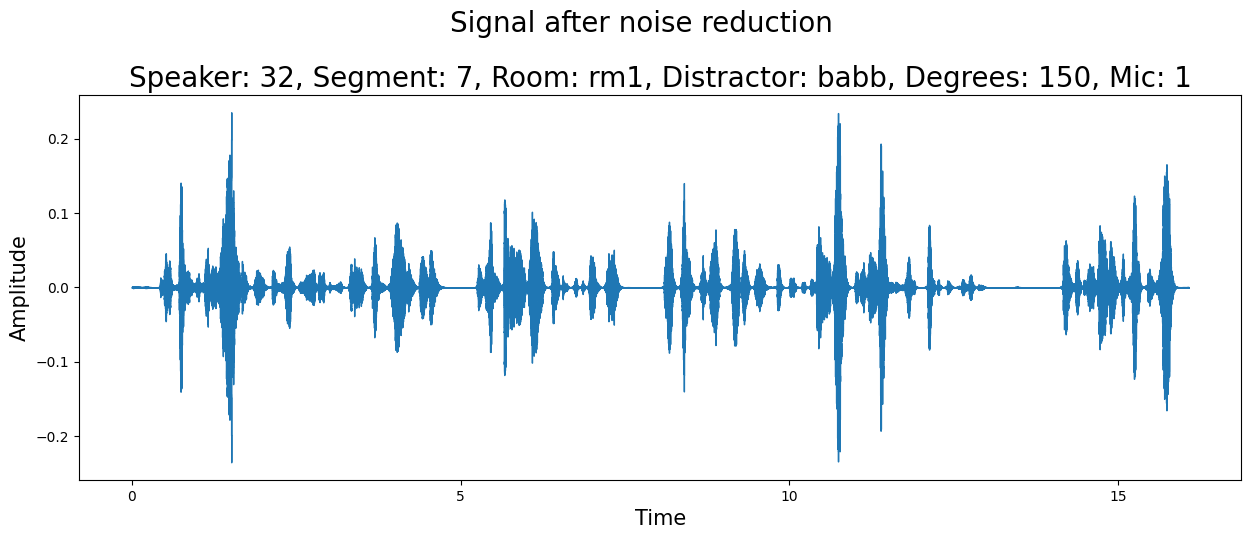

In [16]:

row = df.iloc[0]
signal, sr = librosa.load(row["full_path"])
source_signal, source_sr = librosa.load(row["full_path_source"])

plot_decorate(row, source=True, subtitle="Source signal")
display_waveplot(source_signal, source_sr)
plt.savefig("docs/ex_source_signal.png")

plot_decorate(row, subtitle="Original signal")
display_waveplot(signal, sr)
plt.savefig("docs/ex_original_signal.png")

plot_decorate(row, subtitle="Signal after noise reduction")
display_waveplot(reduce_noise(signal, sr), sr)
plt.savefig("docs/ex_after_noise_reduction.png")

In [ ]:
# save the above plots to a file



If the unwanted noise or distractors are clearly visible or identifiable in the time-domain representation of the audio signal, performing noise reduction directly in the time domain (before conversion to spectrogram) may preferred. This can help preserve the essential characteristics of the signal before further analysis, such as generating spectrograms for subsequent processing steps in tasks like speaker verification.

# Pre-processing pipeline


In [17]:
# Load 10 random samples from the train category
df = df_merged[df_merged["category"] == "train"]
df = df.sample(10, random_state=42).reset_index(drop=True)

print(df)

   index  chapter  degrees distractor  \
0   8109   164461      110       none   
1   9515    34605      170       tele   
2   4238    12312       40       musi   
3    197    28452       20       musi   
4  11476   128145      150       tele   
5  11138   292138      150       babb   
6   7114    27120        0       babb   
7   3251     4137      150       babb   
8  11996    82991       60       tele   
9   8448   123172       20       none   

                                            filename gender  mic  \
0  distant-16k/speech/train/rm3/none/sp2162/Lab41...      M    5   
1  distant-16k/speech/train/rm3/tele/sp6147/Lab41...      F    1   
2  distant-16k/speech/train/rm2/musi/sp0254/Lab41...      M    5   
3  distant-16k/speech/train/rm1/musi/sp3235/Lab41...      F    1   
4  distant-16k/speech/train/rm4/tele/sp1271/Lab41...      M    5   
5  distant-16k/speech/train/rm4/babb/sp8605/Lab41...      F    1   
6  distant-16k/speech/train/rm3/babb/sp1259/Lab41...      F    5   
7  d

In [18]:
reduce_noise(signal, sr).shape

(354344,)

In [19]:
# Example
signals_and_srs = [librosa.load(row["full_path"]) for _, row in df.iterrows()]

In [20]:

def reduce_noise(signal, sr):
    """
    Reduce noise from spectrogram
    """
    noise_reduced = nr.reduce_noise(signal, sr=sr)
    return noise_reduced

def pad_trim_audio(signal, sr, length=15):
    """
    Pad or trim audio signal to a fixed length
    """
    target_length = sr * length
    if len(signal) > target_length:
        clean_signal = signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        clean_signal = np.pad(signal, (0, pad_width), 'constant')
    return clean_signal

# may need to play around with these parameters
def compute_spectrogram(signal, n_fft=2048):
    """
    Compute spectrogram of audio signal
    win_length: window length in samples, smaller values for better temporal resolution. Default is win_length=n_fft
    hop_length: number of samples between successive frames, smaller values increase number of columns D . Default
    is hop_length=win_length//4
    """
    spectrogram = librosa.stft(signal, n_fft=n_fft)
    spectrogram = np.abs(spectrogram)
    return spectrogram

def convert_to_decibel(spectrogram):
    """
    Convert spectrogram to decibel
    """
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram

def compute_melspectrogram(signal, n_mels=128):
    """
    Extract mel-spectrogram from audio signal
    """
    spectrogram = librosa.feature.melspectrogram(S=signal, n_mels=n_mels)
    return spectrogram

def compute_mfcc(melspectrogram, n_mfcc=20):
    """
    Extract MFCC from Mel-spectrogram
    """
    spectrogram = librosa.feature.mfcc(S=melspectrogram, n_mfcc=n_mfcc)
    return spectrogram




In [31]:
# step 1 Merge segments
# step 2. Denoise
signal1 = reduce_noise(signal, sr)
signal2 = pad_trim_audio(signal1, sr) # 30-32 seconds
signal3 = compute_spectrogram(signal2)
signal4 = convert_to_decibel(signal3) #check rms
# extract Mel-spectrogram from STFT
signal5 = compute_melspectrogram(signal4, n_mels=128)
# extract MFCCs from Mel-spectrogram
signal6 = compute_mfcc(signal5, n_mfcc=20) # 10-20 used commonly
#spID 001
#N=<N, varies,499>
# <130+10=140, 499>
# stack output of Mel and MFCC
# 1 row for audio file(same as for speaker) --N=300;
# (300x140)
# spearman correlation coeffcient, sort
# high correlation between feature 110 & 115 = pick one

# 300x32=9600
# if keep all distractor combos, final data is (9,600xnumber of features selected, 499)

In [32]:
signal5.shape

(128, 646)

In [33]:
signal6.shape

(20, 646)

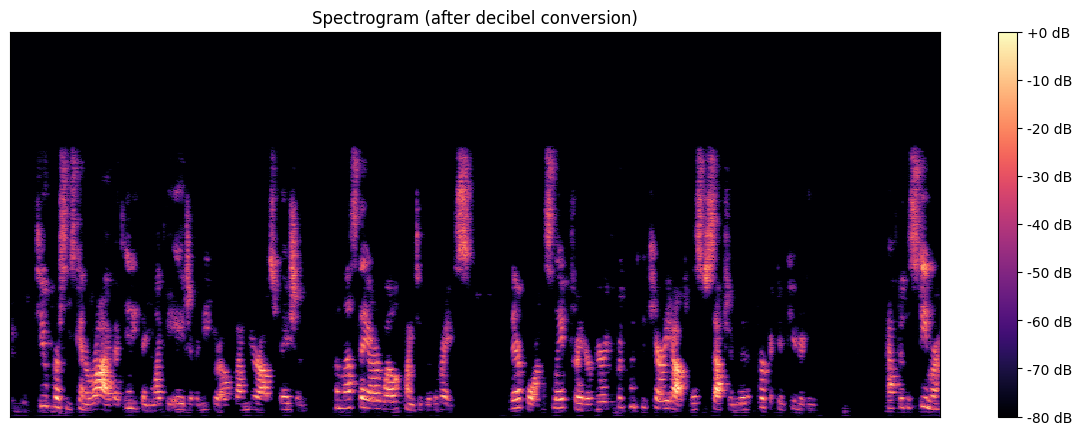

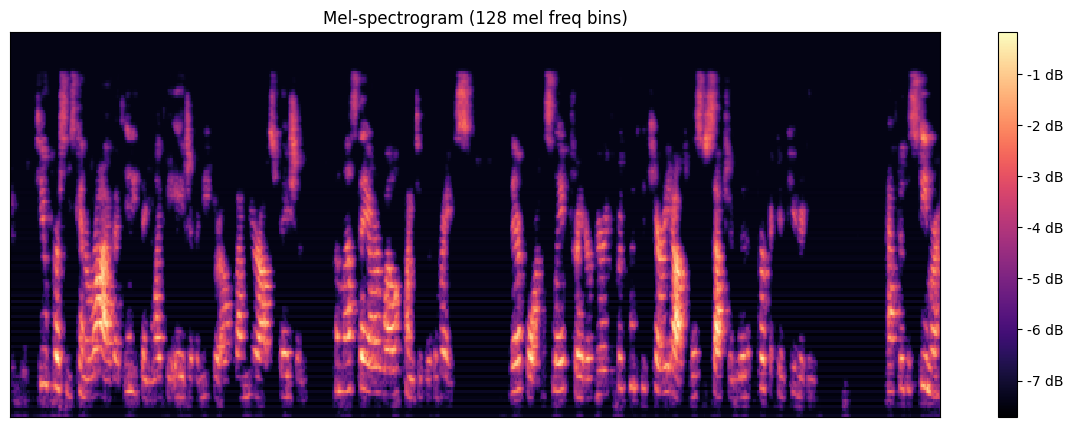

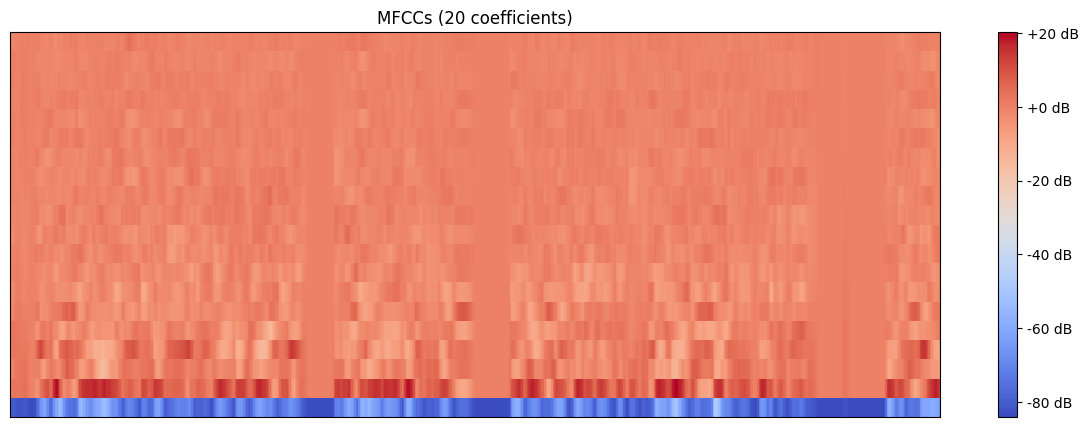

In [34]:
display_spectrogram(signal4, title="Spectrogram (after decibel conversion)")

display_spectrogram(signal5, title="Mel-spectrogram (128 mel freq bins)")

display_spectrogram(signal6, title="MFCCs (20 coefficients)")


The Mel spectrogram provides a detailed representation of the energy distribution across Mel-frequency bands, while MFCCs offer a compact representation of the spectral characteristics, often used as features in various audio processing applications.

### Mel-spectrogram

- high-dimensional representation of the spectral content of the audio signal. Each time step of the spectrogram
corresponds to a different frequency band.
- Mel spectrograms retain detailed information about the energy distribution across different frequency bands
- visually interpretable

### MFCCs

- MFCCs offer a more compact representation compared to Mel spectrograms. The discrete cosine transform (DCT) applied to the logarithm of the Mel spectrogram results in a reduced set of coefficients.
- First few MFCC coefficients often capture the most relevant spectral characteristics, making them efficient for tasks where the detailed frequency content may not be as crucial.




CNNs can learn to extract relevant features from the spectrogram representation, while RNNs can learn to model the temporal dependencies in the spectrogram sequence. Given enough computational resources, using Mel spectrograms may be better. In our case of distinguishing speakers based on their voice characteristics, the detailed frequency information in Mel spectrograms might be beneficial to a deep neural network.

Task: Train separate models with each representation and compare their performance on our validation set.

In [1]:
# Read all data from pickle file
# For all speaker samples
# 1. Denoise
# 2. Compute spectrogram
# 3. calculate the DWT distance between denoised spectraogram and original sample spectrogram
# 4. calculate the DWT distance between spectraogram and original sample spectrogram
# 5. stack the DWT distances for each sample




In [6]:

row = df.iloc[0]
signal, sr = librosa.load(row["full_path"])
source_signal, source_sr = librosa.load(row["full_path_source"])

In [17]:
df

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,transcript,noisy_length,noisy_sr,noisy_time,source_length,source_sr,source_time,category,full_path,full_path_source
0,893,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
1,895,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
2,280,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
3,282,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
4,2969,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,780,283228,130,musi,distant-16k/speech/test/rm4/musi/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-musi-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19196,1471,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19197,1470,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19198,975,283228,130,tele,distant-16k/speech/test/rm4/tele/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-tele-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...


In [35]:
# create a column concatinating speaker-segment-distractor-mic (convert to str type first)
df["sample_id"] = df["speaker"].astype(str) + "-" + df["segment"].astype(str) + "-" + df["distractor"] + "-" + \
                  df["room"] + "-" + df["mic"].astype(str) + "-" + df["degrees"].astype(str)

In [38]:
df["speaker_segment"] = df["speaker"].astype(str) + "-" + df["segment"].astype(str)

df["signal_alterations"] = df["distractor"] + "-" + df["room"] + "-" + df["mic"].astype(str) + "-" + df["degrees"].astype(str)

In [37]:
# get count of samples per sample_id
df["sample_id"].value_counts()

sample_id
8855-7-babb-rm4-1-30    1
8855-7-babb-rm4-5-30    1
8855-7-musi-rm4-1-30    1
8855-7-musi-rm4-5-30    1
8855-7-none-rm4-1-30    1
                       ..
32-7-musi-rm1-5-150     1
32-7-none-rm1-1-150     1
32-7-none-rm1-5-150     1
32-7-tele-rm1-1-150     1
32-7-tele-rm1-5-150     1
Name: count, Length: 19200, dtype: int64

In [34]:
# For each speaker_segment
# get original source signal
# for each signal_alterations
# filter data frame to that sample (itterrows()), read the signal
# store the signal

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,noisy_length,noisy_sr,noisy_time,source_length,source_sr,source_time,category,full_path,full_path_source,sample_id
17468,11729,278228,70,tele,distant-16k/speech/train/rm4/tele/sp7932/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-tele-sp7932-ch278228-sg00...,rm4,11,...,265120,16000,16.570,265120,16000,16.570,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp7932/L...,7932-11-tele-rm4-1
17470,11730,93470,120,tele,distant-16k/speech/train/rm4/tele/sp7932/Lab41...,F,1,Lab41-SRI-VOiCES-rm4-tele-sp7932-ch093470-sg00...,rm4,11,...,264240,16000,16.515,264240,16000,16.515,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp7932/L...,7932-11-tele-rm4-1


In [39]:
df

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,noisy_time,source_length,source_sr,source_time,category,full_path,full_path_source,sample_id,speaker_segment,signal_alterations
0,893,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm1-1-150,32-7,babb-rm1-1-150
1,895,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm1-5-150,32-7,babb-rm1-5-150
2,280,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-musi-rm1-1-150,32-7,musi-rm1-1-150
3,282,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-musi-rm1-5-150,32-7,musi-rm1-5-150
4,2969,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-none-rm1-1-150,32-7,none-rm1-1-150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,780,283228,130,musi,distant-16k/speech/test/rm4/musi/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-musi-sp8855-ch283228-sg00...,rm4,11,...,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...,8855-11-musi-rm4-5-130,8855-11,musi-rm4-5-130
19196,1471,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...,8855-11-none-rm4-1-130,8855-11,none-rm4-1-130
19197,1470,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...,8855-11-none-rm4-5-130,8855-11,none-rm4-5-130
19198,975,283228,130,tele,distant-16k/speech/test/rm4/tele/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-tele-sp8855-ch283228-sg00...,rm4,11,...,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...,8855-11-tele-rm4-1-130,8855-11,tele-rm4-1-130


In [40]:
# example
spkr_seg = df[df["speaker_segment"] == "32-7"]


In [85]:

row = df.iloc[0]
source_path = spkr_seg["full_path_source"][0]

source_signal, source_sr = librosa.load(source_path)

tmp = pad_trim_audio(source_signal, source_sr, length=15)
raw_source_signal = tmp
source_spec = convert_to_decibel(compute_spectrogram(tmp, n_fft=2048))

sample_path = spkr_seg["full_path"]

In [100]:
specs, specs_denoised, raw_signals, raw_signals_denoised = [], [], [], []
for _, row in spkr_seg.iterrows():
    signal, sr = librosa.load(row["full_path"])

    clean_signal = pad_trim_audio(signal, sr, length=15)
    spec = compute_spectrogram(clean_signal, n_fft=2048)
    spec = convert_to_decibel(spec)
    raw_signals.append(clean_signal)
    specs.append(spec)

    noice_reduced = reduce_noise(signal, sr)
    clean_signal_noise_reduced = pad_trim_audio(noice_reduced, sr, length=15)
    spec_denoised = compute_spectrogram(clean_signal_noise_reduced, n_fft=2048)
    spec_denoised = convert_to_decibel(spec_denoised)
    raw_signals_denoised.append(clean_signal_noise_reduced)
    specs_denoised.append(spec_denoised)



# convert to numpy array
specs = np.array(specs)
raw_signals = np.array(raw_signals)
specs_denoised = np.array(specs_denoised)
raw_signals_denoised = np.array(raw_signals_denoised)




In [90]:
specs[30].shape

(1025, 646)

In [92]:
source_spec.shape

(1025, 646)

In [102]:
#TODO: change to select a random sample from the speaker-segment of NONE distractor data
# and compute the distance between that and random sample from the speaker-segment of each distractor data

# store the distance in one column in that data frame for that sample vs source
# store the distance in another column in that data frame for that DENOISED sample vs source
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
import time
start = time.time()
distance_no_denoising = dtw_ndim.distance(specs[0], source_spec)
distance_denoising = dtw_ndim.distance(specs_denoised[0], source_spec)
spkr_seg["dwt_no_denoising"] = distance_no_denoising
spkr_seg["dwt_denoising"] = distance_denoising
end = time.time()

print(f"Time taken: {end - start} seconds")

# convert above to a for loop


Time taken: 32.132441997528076 seconds


/var/folders/gx/htb5vl916_j820n434lbd_2dzp39cq/T/ipykernel_33657/4095242046.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spkr_seg["dwt_no_denoising"] = distance_no_denoising
/var/folders/gx/htb5vl916_j820n434lbd_2dzp39cq/T/ipykernel_33657/4095242046.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spkr_seg["dwt_denoising"] = distance_denoising


In [103]:
spkr_seg

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,source_sr,source_time,category,full_path,full_path_source,sample_id,speaker_segment,signal_alterations,dwt_no_denoising,dwt_denoising
0,893,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm1-1-150,32-7,babb-rm1-1-150,6721.158694,8572.99001
1,895,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm1-5-150,32-7,babb-rm1-5-150,6721.158694,8572.99001
2,280,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-musi-rm1-1-150,32-7,musi-rm1-1-150,6721.158694,8572.99001
3,282,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-musi-rm1-5-150,32-7,musi-rm1-5-150,6721.158694,8572.99001
4,2969,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-none-rm1-1-150,32-7,none-rm1-1-150,6721.158694,8572.99001
5,2971,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-none-rm1-5-150,32-7,none-rm1-5-150,6721.158694,8572.99001
6,1621,4137,150,tele,distant-16k/speech/train/rm1/tele/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-tele-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-tele-rm1-1-150,32-7,tele-rm1-1-150,6721.158694,8572.99001
7,1623,4137,150,tele,distant-16k/speech/train/rm1/tele/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-tele-sp0032-ch004137-sg00...,rm1,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-tele-rm1-5-150,32-7,tele-rm1-5-150,6721.158694,8572.99001
8,3251,4137,150,babb,distant-16k/speech/train/rm2/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm2-babb-sp0032-ch004137-sg00...,rm2,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm2-1-150,32-7,babb-rm2-1-150,6721.158694,8572.99001
9,3249,4137,150,babb,distant-16k/speech/train/rm2/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm2-babb-sp0032-ch004137-sg00...,rm2,7,...,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...,32-7-babb-rm2-5-150,32-7,babb-rm2-5-150,6721.158694,8572.99001


In [96]:
distance_no_denoising_independent

245.42187840492275

In [ ]:
# visualize the raw signals in one color as the raw source signal in red color
# annotate the distance for this
#

We extracted the 148 features from Mel-spectrogram (128 Mels) and MFCCs (20). We then aggregated the sequences per sample with a mean. We are attaching 2 heatmaps for the feature correlation (one is for all; the other is for feature combinations with correlation coefficient > |0.8|). We also attached a corresponding list in a csv file.

Out of all possible 148*148=21,904 feature combinations, 3,474 were highly-correlated.

We also performed this after applying denoising (noise reducer algorithm). Here, we had 1,360/21,904 feature combinations that were highly correlated.

Most of the correlations are between the Mel-spectrogram features with each other. We only noticed a few cases where
MFCC coefficients were highly correlated with some of the Mel features. The higher number of highly correlated
features on the non-denoised data may suggest that the background noise signal was




Do these results suggest we could proceed with including both Mel and MFCC features?

In [2]:
import pandas as pd

In [25]:
df_corr_clean_mean = pd.read_csv("data/spearman_correlation_df_mean_cleaned.csv")
df_corr_clean_std = pd.read_csv("data/spearman_correlation_df_std_cleaned.csv")

df_corr_unclean_mean = pd.read_csv("data/spearman_correlation_df_mean_no_clean.csv")
df_corr_unclean_std = pd.read_csv("data/spearman_correlation_df_std_no_clean.csv")

In [27]:
feature1_unclean_mean = df_corr_unclean_mean['coef']
feature1_clean_mean = df_corr_clean_mean['coef']

feature1_unclean_std = df_corr_unclean_std['coef']
feature1_clean_std = df_corr_clean_std['coef']


In [46]:
feature1_unclean_mean.std()

0.2702637332362914

In [34]:
feature1_unclean_mean

0        0.989438
1        0.989438
2        0.987284
3        0.987284
4        0.985050
           ...   
21751    0.000467
21752    0.000424
21753    0.000424
21754    0.000099
21755    0.000099
Name: coef, Length: 21756, dtype: float64

<Axes: >

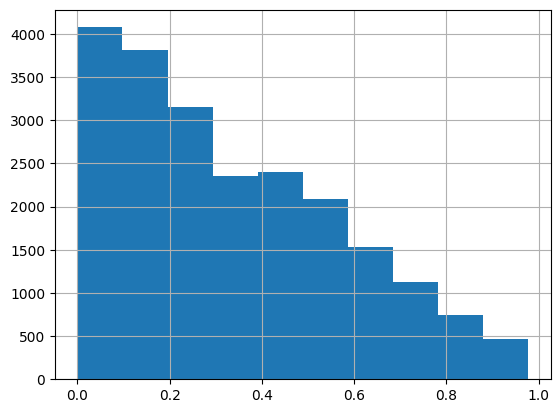

In [28]:
feature1_clean_mean.hist()

In [35]:
feature1_unclean_mean

0        0.989438
1        0.989438
2        0.987284
3        0.987284
4        0.985050
           ...   
21751    0.000467
21752    0.000424
21753    0.000424
21754    0.000099
21755    0.000099
Name: coef, Length: 21756, dtype: float64

In [36]:
# create cat > |0.8| column
df_corr_unclean_mean["cat"] = df_corr_unclean_mean["coef"].apply(lambda x: "high" if abs(x) > 0.8 else "low")
df_corr_unclean_std["cat"] = df_corr_unclean_std["coef"].apply(lambda x: "high" if abs(x) > 0.8 else "low")

df_corr_clean_mean["cat"] = df_corr_clean_mean["coef"].apply(lambda x: "high" if abs(x) > 0.8 else "low")

df_corr_clean_std["cat"] = df_corr_clean_std["coef"].apply(lambda x: "high" if abs(x) > 0.8 else "low")


In [39]:
# get proportion of high and low
df_corr_unclean_mean["cat"].value_counts(normalize=True)

cat
low     0.852363
high    0.147637
Name: proportion, dtype: float64

In [40]:
df_corr_unclean_std["cat"].value_counts(normalize=True)

cat
low     0.928571
high    0.071429
Name: proportion, dtype: float64

In [41]:
df_corr_clean_mean["cat"].value_counts(normalize=True)


cat
low     0.951094
high    0.048906
Name: proportion, dtype: float64

In [42]:
df_corr_clean_std["cat"].value_counts(normalize=True)

cat
low     0.972697
high    0.027303
Name: proportion, dtype: float64

In [32]:
from scipy.stats import ttest_rel

# Perform the paired t-test
t_statistic_mean, p_value_mean = ttest_rel(feature1_unclean_mean, feature1_clean_mean)

t_statistic_std, p_value_std = ttest_rel(feature1_unclean_std, feature1_clean_std)




<Axes: >

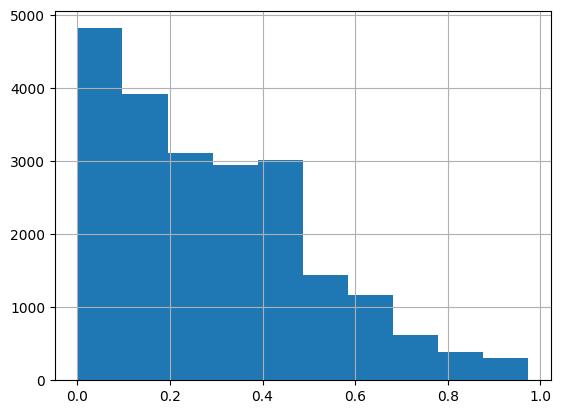

In [30]:
feature1_clean_std.hist()

<Axes: >

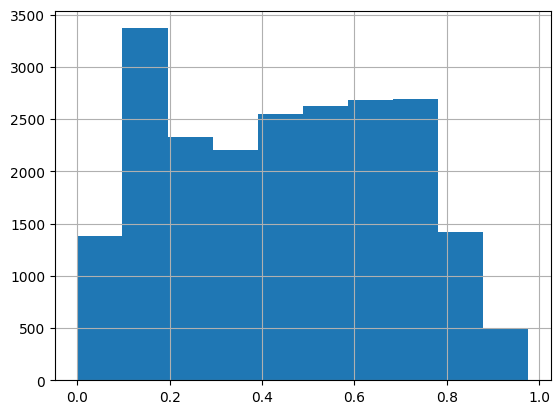

In [31]:
feature1_unclean_std.hist()

In [33]:
# Display the results
print('Paired t-test for correlated features with mean aggregation')
print('------------------------------------------------------------')
print('t-statistic = %.3f' % t_statistic_mean)
print('p-value = %.3f' % p_value_mean)
print('------------------------------------------------------------')
print('Paired t-test for correlated features with std aggregation')
print('------------------------------------------------------------')
print('t-statistic = %.3f' % t_statistic_std)
print('p-value = %.3f' % p_value_std)

Paired t-test for correlated features with mean aggregation
------------------------------------------------------------
t-statistic = 301.078
p-value = 0.000
------------------------------------------------------------
Paired t-test for correlated features with std aggregation
------------------------------------------------------------
t-statistic = 397.657
p-value = 0.000


Null Hypothesis (H0): There is no significant difference in the number of highly correlated features before and after applying the denoising algorithm.

Alternative Hypothesis (H1): There is a significant difference in the number of highly correlated features before and after applying the denoising algorithm.

<Axes: >

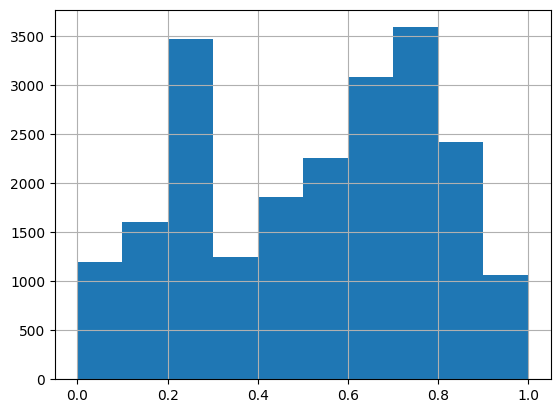

In [15]:
feature1_unclean.hist()

<Axes: >

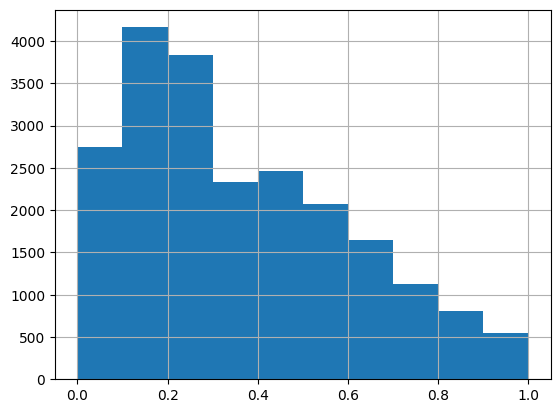

In [14]:
feature1_clean.hist()

In [22]:
feature1_unclean.describe()

count    21756.000000
mean         0.523662
std          0.261418
min          0.000039
25%          0.265103
50%          0.570642
75%          0.746290
max          0.999897
Name: coef, dtype: float64

In [23]:
feature1_clean.describe()

count    21756.000000
mean         0.362536
std          0.243319
min          0.000023
25%          0.169367
50%          0.305282
75%          0.535925
max          0.999943
Name: coef, dtype: float64